In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import cv2
import scipy
import os

In [19]:
epochs = 20
BASE_DIR = '../'
batch_size = 32

In [20]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

    return model

In [21]:
model = get_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 118, 158, 32)      896       
_________________________________________________________________
activation_16 (Activation)   (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 57, 77, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 38, 32)        0         
__________

In [22]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL', 'EOSINOPHIL']:
                label = 'MONONUCLEAR'
            else:
                label = 'POLYNUCLEAR'
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [25]:
X_train, y_train = get_data(BASE_DIR + 'images/TRAIN/')
X_test, y_test = get_data(BASE_DIR + 'images/TEST_SIMPLE/')

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [24]:
model = get_model()

# fits the model on batches
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size)

model.save_weights('binary_model_no_zero_mean_2.h5')

Train on 7965 samples, validate on 1992 samples
Epoch 1/20


ValueError: could not convert string to float: 'MONONUCLEAR'

In [13]:
from sklearn.metrics import accuracy_score

model.load_weights('binary_model_no_zero_mean.h5')
print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
0.985915492958


In [15]:
from sklearn.metrics import confusion_matrix

y_pred_unencoded = np.argmax(y_pred, axis=1)
y_test_unencoded = np.argmax(y_test, axis=1)

print(confusion_matrix(y_test_unencoded, y_pred_unencoded))

[[61  0]
 [ 1  9]]


In [50]:
false_positive_polynuclear = np.intersect1d(np.where(y_pred_unencoded == 0), np.where(y_test_unencoded == 1))

In [58]:
true_positive_mononuclear = np.intersect1d(np.where(y_pred_unencoded == 1), np.where(y_test_unencoded == 1))

In [51]:
false_positive_polynuclear

array([   2,    5,   10,   12,   14,   16,   20,   28,   31,   32,   39,
         40,   49,   52,   54,   64,   65,   66,   67,   68,   75,   78,
         79,   84,   91,   97,  101,  105,  107,  115,  117,  118,  125,
        129,  131,  133,  134,  141,  143,  152,  156,  157,  164,  166,
        168,  173,  176,  179,  205,  206,  212,  215,  216,  217,  219,
        220,  227,  228,  239,  243,  251,  252,  253,  255,  268,  270,
        275,  276,  277,  295,  298,  309,  311,  316,  317,  320,  323,
        326,  327,  328,  329,  330,  340,  347,  372,  373,  381,  382,
        385,  386,  387,  388,  389,  391,  396,  402,  403,  406,  407,
        410,  412,  413,  416,  425,  427,  428,  430,  431,  434,  440,
        441,  445,  447,  449,  454,  459,  460,  462,  471,  474,  476,
        482,  483,  484,  485,  486,  490,  491,  499,  500,  501,  504,
        512,  513,  532,  535,  536,  537,  544,  548,  553,  554,  559,
        567,  568,  579,  580,  583,  589,  591,  6

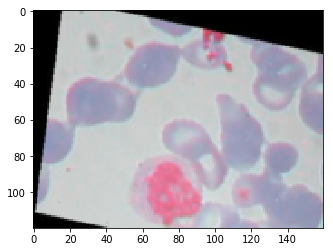

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_test[false_positive_polynuclear[7]])

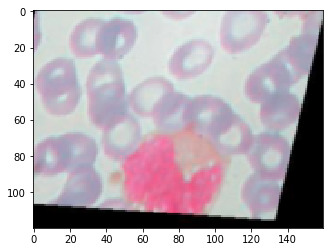

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_test[true_positive_mononuclear[15]])

In [68]:
model.predict_proba(X_test[10:11])

1/1 [==============================] - 0s


array([[  1.00000000e+00,   2.07605293e-08]], dtype=float32)

In [105]:
false_positive_mononuclear = np.intersect1d(np.where(y_pred_unencoded == 1), np.where(y_test_unencoded == 0))

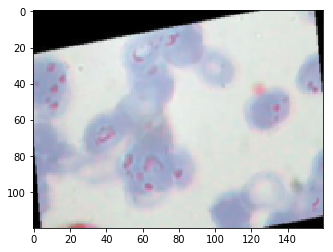

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_test[false_positive_mononuclear[6]])

In [108]:
len(false_positive_mononuclear)

9

In [15]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test_simple))

print(accuracy_score(y_test_simple, y_pred))

Predicting on test data
0.830985915493


In [16]:
from sklearn.metrics import confusion_matrix

y_pred_unencoded = np.argmax(y_pred, axis=1)
y_test_simple_unencoded = np.argmax(y_test_simple, axis=1)

print(confusion_matrix(y_test_simple_unencoded, y_pred_unencoded))

[[10  0  0  3]
 [ 1  5  0  0]
 [ 0  0  3  1]
 [ 6  0  1 41]]


In [148]:
 false_positive_polynuclear = np.intersect1d(np.where(y_pred_unencoded == 0), np.where(y_test_simple_unencoded == 1))

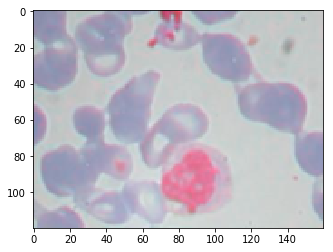

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_test_simple[false_positive_polynuclear[0]])